### Introduction to Dask 

Computers have mutliple cores in the CPU to optimise the code you should use multiple cores to execute tasks that are independent from each other.

#### Multi-threading
You could split these tasks into two, or three threads in parallel within a single Python process. This is called multi-threading. 

#### Parallel processing 
parellel processing is also taking multiple threads however the threads are running different instances of pythons scripts. So you have two processes. 


### Parallel programming with Dask
Dask can be used to facilitate parallel programming with lazy evaluation. Variables are not computed to the point in the script when it's actually needed. Instead a task list is created and when the variable is needed, then it's computed. The multiple tasks are split over multiple proccesses/threads to compute faster.

To implement you can use the dask delayed function

```
from dask import delayed
def my_square_function(x):
   return x ** 2 

delayed_function = delayed(my_square_function) 
```

The delayed function takes in another function and will return a delayed object, the original function has not been run yet. 

In [9]:
from dask import delayed 

def my_square_function(x):
    return x ** 2 

# Here you store the steps for the function 
delayed_function = delayed(my_square_function)

# Here you store the steps for the function with an impute 
delayed_result = delayed_function(2)

# Here you compute the delayed function with the input that was given before 
print(delayed_result.compute())

4


#### Delayed object 

On the delayed object you can also perform standard mathematical equisions and this will return another delayed object. You can call the result of that object by running the compute function again.

In [13]:
# Creathing the delayed fucntion
delayed_function_2 = delayed(my_square_function)

# Giving the int value to delayed function and other mathematical operations 
delayed_result_2 = (4 + delayed_function_2(4)) * 5 

# Compute the result 
delayed_result_2.compute()

100

#### Parallel processing

In the example below you'll see how a list of ints can be multithreaded by using a delayed function. In this instance the squaring of the different ints will happen on different processes which in turn will make it faster. It won't be running on a single thread anymor. default threads 

In [16]:
x_list = [3, 6, 7, 12, 53, 234, 5212, 10049]

sum_of_squares = 0

for i in x_list:
    sum_of_squares += delayed_function(i)

result = sum_of_squares

result # <== this is a delayed variable 
result.compute() #<== this returns the answer that we seek computed on mutliple threads 

128205148

#### Sharing computation 

Sometimes the intermediate result is not computed immediately but it is used twice. See the example below. This would be slower because it has to compute the same result twice which is inefficient. 

In [17]:
delayed_intermediate = delayed(my_square_function)(3)

# Since the intermediate is used twice for different functions 
delayed_result_x = delayed_intermediate - 5
delayed_result_y = delayed_intermediate + 4

# The intermediate is calculated twice 
print('delayed result x :', delayed_result_x.compute())
print('delayed result y :', delayed_result_y.compute())

delayed result x : 4
delayed result y : 13


This can be mitigated by computing two of the intermediates in a single compute 

In [23]:
import dask 

delayed_intermediate = delayed(my_square_function)(3)

# Since the intermediate is used twice for different functions 
delayed_result_x = delayed_intermediate - 5
delayed_result_y = delayed_intermediate + 4

# Now you compute the results only ones, they use the same intermediate anyway so it doesn't matter
delayed_result_x_1, delayed_result_y_1 = dask.compute(delayed_result_x, delayed_result_y)

# Results are the same 
print('delayed result x 1 :', delayed_result_x_1)
print('delayed result y 1:', delayed_result_y_1)

delayed result x 1 : 4
delayed result y 1: 13


In [20]:
# Please mind how the arguments of the delayed function have to be given to dask 
from dask import delayed
import numpy as np 

costs_week_1 = [2, 4, 5, 6, 7]
costs_week_2 = [2, 4, 5, 6, 7]


# Lazily calculate the sums of costs_week_1 and costs_week_2
sum1 = delayed(np.sum)(costs_week_1)
sum2 = delayed(np.sum)(costs_week_2)

# Add the two delayed sums
total = sum1 + sum2

# Compute and print the final answer
print(total.compute())

48


### Task graphs and scheduling methods 

When we want to see what the order of operation is for a specific dask process we can use the visualize method. The visualisation that is produced is read from bottom to top and show which sources are being used and which transformations are being ran upon them. 

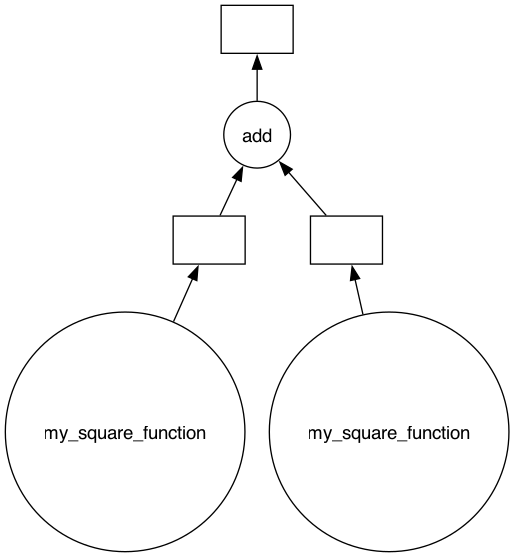

In [22]:
delayed_num1 = delayed(my_square_function)(3)
delayed_num2 = delayed(my_square_function)(5)

# Add the two delayed numbers together 
result = delayed_num1 + delayed_num2 

# Visualise the order of operation 
result.visualize()

When there are mutliple operations done on a intermediate that has the same input you have to give both the values to the visualize function to see how they're both being processed. If they're sepperate you cannot see how they're bing calculated together if that makes sense

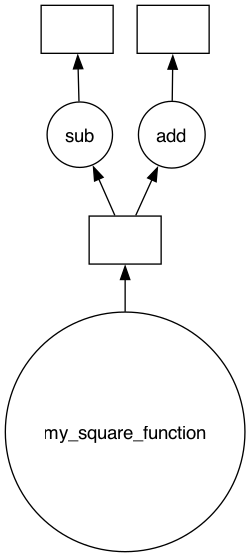

In [33]:
delayed_intermediate = delayed(my_square_function)(3)

def addition_function(x):
    return x + 5 

extra_delayed_intermediate = delayed(addition_function)(5)

# Since the intermediate is used twice for different functions 
delayed_result_x = delayed_intermediate - 5
delayed_result_y = delayed_intermediate + 4


final_result = delayed_result_x + delayed_result_y - extra_delayed_intermediate

# Now you compute the results only ones, they use the same intermediate anyway so it doesn't matter
# dask.visualize(final_result) #<== this also works because they're dependent 
dask.visualize( delayed_result_x, delayed_result_y)

### Multi threading vs Parallel Processing 

#### Parrallel processing 
- The processes have their own RAM space 
- Uses multiple python instances 
- Take time to start up but slower than threads

#### Multithreading
- Threads use the same RAM space 
- Uses only one python instance 
- Take time to start up but faster than parallel processing 


#### Adding the sum of two lists 

So for example if you use Parallel processing which has their OWN RAM space. In the case where you're making an addition two new processes are started and the arrays need to be copied over. Which is extremely slow. Then after the calculation has been made, it needs to be copied back again to the main process. So an array is copied over three times in total. 

With multithreading the process still share a RAM space so it's much quicker nothing needs to be copied over. and the process is just ran on multiple threads. within the RAM space. 


### GIL lock 

Python unlike other programming languages has a GIL lock. This prevents other threads from reading the same python script at the same time, ones that a thread knows the commands the script can be passed on to the next. That means that if the steps in a certain script are short a lot of unnecesary time will be spent reading the scripts. With parallel processing where they have their own ram and running the script in their own environment this time will be way shorter because they have their own GIL. 

### When processes are better. 

Let's say you have a script which you want to execute three times. If you use multithreading then the multiple threads will block each other out. Only one thread can execute the script at the same time and since it's a singular script it's not like the other threads can execute a certain script. in this case parallel processes will be quicker because they can execute the script at the same time and will not be blocked out. It might take a while for the parallel processes to start but ones they do they can execute it way faster.

### GIL lock free functions 

There are also functions which remove the GIL lock to make sure that the threads don't block each other. `pd.read_csv` is one of those functions. 

### Building delayed pipelines 
Dask is also a very usefull tool to build pipelines to process large amount of data. Once the dataframe becomes too large it will become impossible to load the entire dataset into memory at once. To still be able to use large dataframes it is loaded and processed into chunks, smaller representations of the dataset. This is slower in general but Dask can be used to speed up this process. 

#### Case: Finding max track length of large spotify dataset 

In [ ]:
import pandas as pd 

files = ['2020', '2021', '2022', '2023', '2024']

maximums = []

for file in files:
    df = pd.read_csv(file)
    max_length = df["track_duration"].max()
    maximums.append(max_length)

longest_track = maximums.max() 

#### Converting into lazy loading 
To transfor this function and use multithreading or parallel processing we need to make adjustments to the df = pd.read_csv line to delay the actual loading of the dataframe. This is where we kind of start with making it lazy if that makes any sense. 

We also delay the final max function, there is nothing there yet so what would we be maxing out? 

The max_length line also becomes a delaid object. Since it is derrived from pd.read_csv which has been delayed it also becomes a delayed opbject. "Using a method of delayed object returns a delayed object, the same goes for accessing properties of the object"

If a method or fucntion is called that belongs to an object which doesn't exist or is maybe wrong you will only receive the eroror after the object has been called through a compute function

Now that we append max_length to the maximums list it becoems a list of delayed methods. maximums can be in turn given back to a delayed max function `delayed(max)(maximums)` in turn the list of maximums can be computed with `dask.compute(maximums)` remember it's a list of delayed objects. this returns a tuple of a with a list of results inside which can be accessed by referencing the 0th value [0]

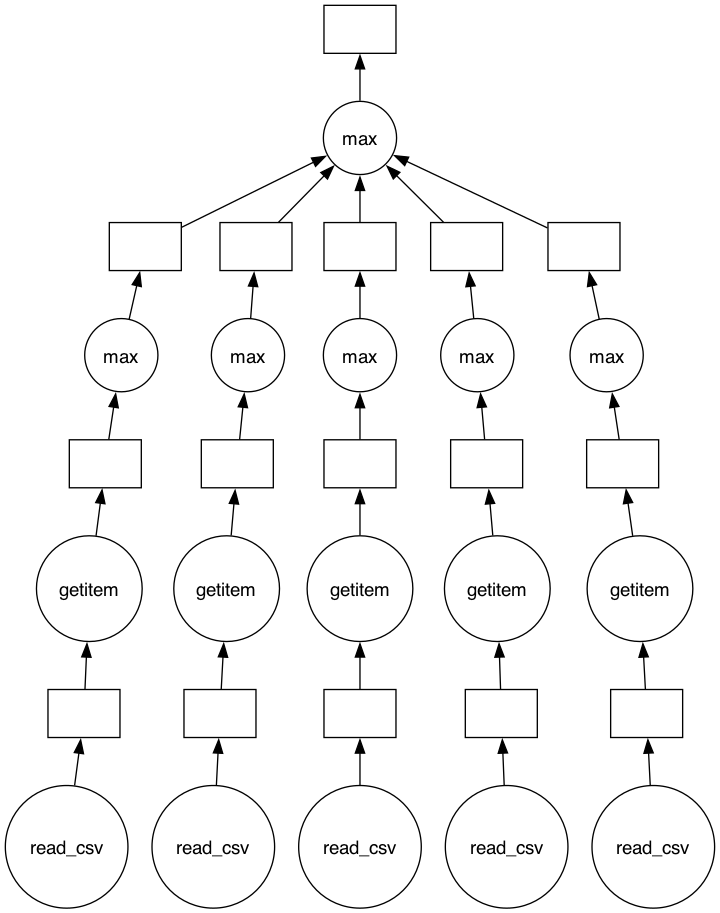

In [34]:
import pandas as pd 
import dask 
from dask import delayed

files = ['2020', '2021', '2022', '2023', '2024']

maximums = []

for file in files:
    df = delayed(pd.read_csv)(file)
    max_length = df["track_duration"].max()
    maximums.append(max_length)

longest_track = delayed(max)(maximums)

dask.visualize(longest_track)

#### An examples 

In [ ]:
danceabilities = []

for file in filenames:
	# Lazily load in the data
    df = delayed(pd.read_csv)(file)
    # Calculate the average danceability in the file of songs
    mean_danceability = df['danceability'].mean()
    danceabilities.append(mean_danceability)

# Compute all the mean danceabilities
danceability_list = dask.compute(danceabilities)[0]

# Plot the results
plt.plot(years, danceability_list)
plt.show()

In [ ]:
filenames = [] #<== a song databse 

n_songs_in_c, n_songs = 0, 0 

for file in filenames:
    # Load in the data
    df = delayed(pd.read_csv)(file)
    
    # Add to running totals
    n_songs_in_c += (df['key'] == 'C').sum()
    n_songs += df.shape[0]

# Efficiently compute total_n_songs_in_c and total_n_songs
total_n_songs_in_c, total_n_songs = dask.compute(n_songs_in_c, n_songs)

fraction_c = total_n_songs_in_c / total_n_songs
print(total_n_songs, fraction_c)

### Dask Arrays 

The dask Library also carries more specialized parts for the multithreading and multiprocessing of applications. Like Dask Arrays these are a specialized form of arrays that divide a regular np array in even more chunks, because why the fuck not? 

It could be that a hugely structured np array which is 4000, 4000 (4000 rows and 4000 columns) should be split up into smaller arrays so it can be processed by our RAM a dask array does that. In a Dask array every array is a numpy array. Then when we want to perform an analysis over the full dataset dask loads it in piece by by piece. 

In [58]:
import numpy as np 
import dask.array as da 


# Creating a numpy array of 4000 rows by 6000 columns 
npa = np.ones((4000, 6000))

# Creating a dask array of a numpy array of 4000 rows and 6000 columns divided by chungs the with the size of 2000, 2000
daa = da.ones((4000, 6000), chunks=(1000, 2000))

print(npa.shape)
print(daa.shape)

import time 
start_time_np = time.time()
sum_numpy = npa.sum()
end_time_np = time.time()

start_time_da = time.time()
sumd_dask = daa.sum().compute()
end_time_da = time.time()

# Dask is almost 10 times faster ... 
print(f'Total time for numpy is ', end_time_np - start_time_np)
print(f'Total time for dask is ', end_time_da - start_time_da)


(4000, 6000)
(4000, 6000)
Total time for numpy is  0.008280754089355469
Total time for dask is  0.005714893341064453


Dask arrays have all the same functions as numpy arrays. Functions like 
- max()
- min()
- sum()
- mean()

When these functions are run dask will return another lazy numpy array. And ones the compute method is called on the array then we will get a numpy array as a final value. 

#### Image loading 

You can also use dask arrays to load in images using the da.image module. Sometimes you want to run a function across an entire array but for each chunk specifically. To do this we use the image arrays .map_block() function. Here every chunk is taken specifcally instead of the function being ran over the whole dask array. After that you pass in a function.

This will result in another lazy array. Which can in the end be executed with compute()

In [ ]:
import dask.array as da 
import da.image 

# Define the function which you want applied
def negative_colours(image):
    a, b, c = image.strip()
    return a+1, b+1, c+1 

# Load all the images in a certain folder 
image_array = da.image.imread('somefile/*.png')

# Apply the function to each block specifically 
negative_colours = image_array.map_blocks(negative_colours)


#### Example 

In [ ]:
# Convert the color photos to grayscale
grayscale_images = image_array.mean(axis=3)

# Apply the edge detection function
edge_images = grayscale_images.map_blocks(compute_edges)

# Select the zeroth image and compute its values
sample_image = edge_images[0].compute()

# Show the result
plt.imshow(sample_image, cmap='gray')
plt.show()

### Dask Dataframes 

Dask also has a specific module for working with tabular dataframes called dask.dataframe (imported as dd) 

It has almost all of the same functions as a pandas dataframe but will do so lazily so for example if a dataset has multiple partitions or is too big we can lazily load them in like this.

A .head() can also be used to get al ook into a dataframe it will take a quick glance into the dataframe and based on that decide what the columns are and give a quick head. 

You can also partition the dataframe when you save it to disk again, making sure that you don't go over your available RAM size 

In [ ]:
import dask.dataframe as dd 

# Here we read all of the data sets in a certain folder and partition them by a specific size.
# If we don't give the blocksize for the partition it will partition based on the n of files 
dask_dataframe = dd.read_csv(
    'datasets/*.csv', 
    blocksize='10MB'
)

# finds the top 3 largest value based on a certain column
dask_dataframe.nlargest(n=3, columns='col1')

dask_dataframe.to_csv("outpub/part-*.csv")


#### HDF5 

hdf5 is a popular method of storing multiple large tabular datasets within each hdf5 file there can be multiple datasets. The keys of the file can easily be accessed as if it was a python dictionary by running 

```
import h5py

# Open HDF5 file 
file = h5py.File('data.hdf5')
```

`file.keys()`

This will result in the different datasets within the hdf5 file 

to select a dataset you can use the key and extract the dataset 

`dataset_a = file['/A']`

after printing the dataset you can see it's shape and datatype the data within hasn't been loaded yet. You can access the data within the array by using dask again. Then you give the chunksize to determine how the dat will be split up without being computed yet.

```
import dask.array as da 

# Load in the data 
dask_a = da.from_array(dataset_a, chunks=(100, 20, 20))
```

The chunks should be smaller than the entirety of the array but small enough that multiple can be loaded on multiple threads or within multiple processes. 


In [ ]:
# WTF???!!!

# Open the HDF5 dataset using h5py
hdf5_file = h5py.File('data/era_eu.hdf5')

# Load the file into a Dask array with a reasonable chunk size
precip = da.from_array(hdf5_file['/precip'], chunks=(12, 15, 15))

# Select only the months of January
january_rainfalls = precip[0::12]

# Calculate the mean rainfall in January for each location
january_mean_rainfall = january_rainfalls.mean(axis=0)

plt.imshow(january_mean_rainfall.compute())
plt.show()

### Zarr 

Like HDF5 is zarr is a file format which is hierarchal. It has been made with chunking in mind and is good for streaming data in combination with cloud computing. 

Unlike HDF5 you can open and look into the Zarr file using a file browser to see what exactly is within the Zarr file to see each chunk of each array. 

```
import dask.array as ad 

a = da.from_zarr('dataset.zar', component='A')

```

You need to specify which part or component of the zarr file you want to load. Dask will automatically choose the same chunksize which are on disk (no fucking idea what the fuck that means but okay? apperantly they're saved within the metadata of the zarr file)




### Xarray 

An Xarray dataset is a dataset like pandas but then three dimensional because why not just fuck your whole fucking life up fuck this. Anyways yes hmm interesting you can load in an Xarray by doing whatever the fuck. 

```
import xarray as xr 

ds = xr.open_zarr("data/era_eu.zarr")
```


In [74]:
import xarray as xr 
import dask.array as da 

xrds = da.from_zarr("./data/era_eu.zarr", component='lon')
try:
    ds = xr.open_zarr("./data/era_eu.zarr")
except Exception as e:
    print(e)



unrecognized engine zarr must be one of: ['store']


### Unstructured Data with Dask 

You can use make use of unstructured data in combination with dask using the dask bags.

To create a dask bag, which is a lazy loaded list, you can use the from_sequence function. There you can give a datasource (lists/dicsts) and how many partitions it should be stored in. Then once you want the values out of the list, you can compute them or visualize how the computation will be executed.

#### Dask take 
To extract values from the dask bag you can use the take function. it reutrns a tuple of items from the bag. if you want to see all of the elements you would use the compute method 

#### Dask count 
you can use the .count() method to see how many values are in the entire bag. Do note that the result needs to be computed before they can be displayed. 

#### Loading text 
Dask has a specific method for reading text in an unstructured datasource it uses the read_text function. You passs in the filenames which you want to read in this fashion `text_data_bag = db.read_text('data/*.txt')` this reads all the files that end with txt in the data folder. You can also use `filenames = glob.glob('data/*.txt')` and pass in filenames to `db_read_text(filenames)` it will result in the same. 

By default the partitions will be 1 per text file, so if you have three text files you will have three partitions.

#### String operations 
Ones the text files have been loaded within the bags you can use string accessors to make alterations to the text within the bags. 

Example 
```
print(text_data_bag.str.lower().take(1)) This will lower all the text found in the first index  

print(text_data_bag.str.replace('good', 'great').take(1)) This will replace a text

print(text_data_bag.str.count('great').take(3)) This will count the amount of times great appear in a text
```


In [14]:
import dask.bag as db 

string_list = [
    "first element in the list which is to be loaded",
    "second element in the list which is to be loaded", 
    "Third element is this to be loaded?"
]

# Loads in the list 
bag_example = db.from_sequence(string_list, npartitions=5)

# Take a specific element from the dask bag 
first_string = bag_example.take(1)

bag_count = bag_example.count()
bag_count.compute()


3

### Dask bag operations 
You can apply functions to a bag by using the map function. Then all the files within the bag will be applied that specific function to. This returns a response on which a compute method should be run to extract the values from. 

#### JSON data 
You can use JSON files as well, json is primarily saved in python dictionaries which often er nested. They can be imported and transoformed into a list by using the json.loads function and reading the text with read_text. once it's a dictionary bag you can also use `filter` to apply functions to the bag. 


In [49]:
employment_dict = [
    {
        "name": "Josh",
        "employment": [
            {
                "role": "Manager",
                "start_date": "01012002",
                "end_date": "12312010",
                "location": "New York",
                "salary": 85000,
                "department": "Sales"
            },
            {
                "role": "Senior Manager",
                "start_date": "01012011",
                "end_date": "Present",
                "location": "New York",
                "salary": 105000,
                "department": "Sales"
            }
        ]
    },
    {
        "name": "Emily",
        "employment": [
            {
                "role": "Software Engineer",
                "start_date": "05012015",
                "end_date": "08312018",
                "location": "San Francisco",
                "salary": 95000,
                "department": "Engineering"
            },
            {
                "role": "Lead Engineer",
                "start_date": "09012018",
                "end_date": "Present",
                "location": "San Francisco",
                "salary": 130000,
                "department": "Engineering"
            }
        ]
    },
    {
        "name": "Michael",
        "employment": [
            {
                "role": "Analyst",
                "start_date": "01012010",
                "end_date": "03312014",
                "location": "Chicago",
                "salary": 60000,
                "department": "Finance"
            },
            {
                "role": "Senior Analyst",
                "start_date": "04012014",
                "end_date": "06302019",
                "location": "Chicago",
                "salary": 75000,
                "department": "Finance"
            },
            {
                "role": "Finance Manager",
                "start_date": "07012019",
                "end_date": "Present",
                "location": "Chicago",
                "salary": 95000,
                "department": "Finance"
            }
        ]
    },
    {
        "name": "Sophia",
        "employment": [
            {
                "role": "HR Coordinator",
                "start_date": "02012018",
                "end_date": "06012020",
                "location": "Los Angeles",
                "salary": 55000,
                "department": "Human Resources"
            },
            {
                "role": "HR Manager",
                "start_date": "07012020",
                "end_date": "Present",
                "location": "Los Angeles",
                "salary": 75000,
                "department": "Human Resources"
            }
        ]
    }
]


In [47]:
import json 

# Define a simple function
def count_words(sentence: str):
    word_list = sentence.split(' ')
    return len(word_list)

# Apply the map and compute to get the results 
bag_example.map(count_words).compute()

# reading in a json file 
json_bag = db.read_text('./data/*.json')

# when using json this will convert it from a json string to a python dictionary
bag_dict = json_bag.map(json.loads)
bag_dict.compute()

# Define a filtering for dict 
def title_what_json(dict):
    return dict is not None 

# Applies the filter to the bag that was produced 
filter_bag = bag_dict.filter(title_what_json)  
filter_bag.compute()

# This can also be done using lambda functions, this will apply the lambda function for all items with the bag
lambda_bag = bag_dict.filter(lambda x: x is not None)
lambda_bag.compute()

new_employee_bag = {}

employment_bag = new_employee_bag.pluck('employment') # This will take whatever comes after the key in the dict 

# Ones this kind of filtering has been performed it can be chained to find even more information 
employment_bag.map(len) # or something like that 

# Furthermore you can ofcourse use aggregates on numerical values one they have been computed. 
# Using dask in this setting will ensure that you'll constantly only be fetching the items thaty ou truly need 


[{'course': {'id': 101,
   'title': 'Introduction to JSON',
   'description': "A beginner's course on JSON format and structure.",
   'instructor': {'name': 'Jane Doe', 'email': 'jane.doe@example.com'},
   'modules': [{'module_id': 1,
     'module_title': 'What is JSON?',
     'topics': ['Overview of JSON', 'Syntax and Structure']},
    {'module_id': 2,
     'module_title': 'Working with JSON',
     'topics': ['Parsing JSON', 'JSON in Web Development']}],
   'students_enrolled': 50,
   'active': True}}]

#### Converting unstructured data to a dataframe 
In a lot of cases unstructured data is converted into a structred dataframe. However very often there are nested functions within a dataframe which need to be unnested first before turning the bag back into a dask dataframe. 

Steps of action 
1. Find the information that you would actually like to use. 
    1. Make a custom function and apply that to the dictionary 

```
def add_number_of_jobs(emplyee_dict):
    employee_dict['number_of_previous_jobs'] = len(employee_dict['employmnet'])
    return employee_dict

dict_bag = dict_bag.map(add_number_of_jobs) 
```
2. In this example we will be removinge elements based where there is a second argument next to self

```
def delete_dictionary_entry(dictionary, key_to_drop):
    del dictionary[key_to_drop]
    return dictionary 

dict_bag = dict_bag.map(delete_dictionary_entry, key_to_drop='employment')
```

2. EXTRA you can also drop more keys than you want to keep, because why make this fucking easy for yourself? 
```
def filter_dictionary(dictionary, keys_to_keep):
    new_dict = {}
    for k in keys_to_keep:
        new_dict[k] = dictionary[k]
    return new_dict 

dict_bag = dict_bag.map(filter_dictionary, keys_to_kee=['first', 'second'])
```

3. finally you can convert them to a dataframe using the bags .to_dataframe() function

### Using processes and threads 

As discussed earlier we can use both processes or threads whenever we're running a dask application. They both have their upsides and downsides. Threads share a RAM space however they are hurt by the GIL lock that is in place. While parallel processes don't deal with the GIL lock they have an assigned process which makes it so that copying is slower than in a threads environment. 

##### Threads 
- Dask arrays 
- Dask DataFrames 
- Delayed pipelines created with dask.delay()

##### Porcesses 
- Dask bags 

The schedular that you want to you (processes or threads) can be chosen in the scheduler parameter, these can also be set in the dask.compute() function

##### Clusters 
Dask also gives additionl options for the process/threads by importing a LocalCluster 

```
from dask.distributed import LocalCluster

# for using processes 
cluster = LocalCluster( 
    processes=True,
    n_workers=2,
    threads_per_worker=2
)
make two processes and within these processes each process has two treads


# for using threads
cluster = LocalCluster( 
    processes=False,
    n_workers=2,
    threads_per_worker=2
)

make two individual threads and each threads has two threads 
```

here we have different parameters: 
- processes, will it be using processes or not 
- n_workers, How many processes should be created
- threads_poer_worked, how many threads can each of these processes use? 

If the amount of processes and threads is not given dask will decide this for us by looking at our device specifications. 

To use the Cluster that has been created we need to create a Client. The calculation will pass through the client when the process is being ran. 

In [53]:
import dask 
x = dask.delayed(1 + 1)

# Defining processes or threads 

result = x.compute()
# threads 
result = x.compute(scheduler='threads')
# processes 
result = x.compute(scheduler='processes')
# within compute 
dask.compute(x, scheduler='processes')



(2,)

In [62]:
from dask.distributed import Client, LocalCluster 

# creating with LocalCluster
cluster = LocalCluster(
    processes=False,
    n_workers=1,
    threads_per_worker=2
)

client_1 = Client(cluster)
print(client_1)

# creating with Client 
client_2 = Client(
    processes=False,
    n_workers=1, 
    threads_per_worker=2 
)

print(client_2)

<Client: 'inproc://192.168.68.123/21459/9' processes=1 threads=2, memory=16.00 GiB>
<Client: 'inproc://192.168.68.123/21459/16' processes=1 threads=2, memory=16.00 GiB>


/Users/dylan/Documents/school/big_data/scientist_engineer_assignments/.venv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64916 instead
  warnings.warn(
/Users/dylan/Documents/school/big_data/scientist_engineer_assignments/.venv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64918 instead
  warnings.warn(


### Dask in machine learning 
dask_ml is a library which speeds up the machine learning tasks by using multiple threads, processes and other dask mumbo jumbo magic. 

How we use this is by wrapping the model that we would normally use with the dask_ml wrapper 

Example 

```
from sklearn.linear_model import SGDRegressor
from dask_ml.wrappers import Incremental

model = SGDRegressor()

dask_model = Incremental(model, scoring='neg_mean_squared_error')

dask_model.fit(dask_X, dask_y) # Not lazy

```

The model is fit by repeatedly making adjustments to the regression line. A dask fit will only loop through the dataset once, while a regressor does it many times. Why? I don't fucking know and also do not want to find out. 

Calling the fit method won't work to loop through the dataset multiple times, for that reason we must use the partial fit method to get a good fit around the entire dataset. 

```
for i in range(10):
    dask_model.partial_fit(dask_X, dask_y)
```

Then after we've gone through the fitting we can use the model by using the incremental models .predict() method 

```
y_pred = dask_model.predict(dask_X)

print(y_pred.comput())
```


### Machine learning with big datasets 

An important step in regarding making a machine learning model is data preprocessing. And ofcourse Dask has a fucking solution for that as well because fuck meeeee. 

```
import dask.dataframe as dd
dask_df = dd.read_parquet("dataset_parquet")
```

There is a StandardScalar class, which I assume is present in sklearn as well which will make every item a mean of 0 and a deviation of one 

```
from dask_ml.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X) # This is not lazy 

standardized_X = scaler.transform(X) # this is lazy 
```

Splitting shit is done be daskobii as well 

```
from dask_ml.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
print(X_train)
```

after the model has been trained 

```
train_score = dask_model.score(X_train, y_train) # this is not lazy

test_score = dask_model.score(X_test, y_test)
